# Assignment 8 : Xarray

In this assignment, we will use Xarray to analyze top-of-atmosphere radiation data from [NASA's CERES project](https://eosweb.larc.nasa.gov/project/ceres/ceres_table).

![radiation budget](https://upload.wikimedia.org/wikipedia/commons/b/bb/The-NASA-Earth%27s-Energy-Budget-Poster-Radiant-Energy-System-satellite-infrared-radiation-fluxes.jpg)
_Public domain, by NASA, from Wikimedia Commons_

I have pre-downloaded and subsetted a portion of this dataset for use in our class. You can download it here:
http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc. The size of the data file is 702.53 MB. It will take a minute or two to download.

Considering reviewing the [FAQs](https://eosweb.larc.nasa.gov/faq-page/ceres-faq#t67n120) for this dataset before getting started.

Start by importing xarray, numpy, and matplotlib

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1.1) Open the dataset and display its contents 


In [2]:
# ! wget http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc
# ! gunzip CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc

In [53]:
ds = xr.open_dataset('CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc')


## 1.2) Print out the `long_name` attribute of each variable

In [4]:
# ds.solar_mon.long_name

for variable_name, data_array in ds.data_vars.items():
    print(variable_name, data_array.attrs['long_name'])

toa_sw_all_mon Top of The Atmosphere Shortwave Flux, Monthly Means, All-Sky conditions
toa_lw_all_mon Top of The Atmosphere Longwave Flux, Monthly Means, All-Sky conditions
toa_net_all_mon Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions
toa_sw_clr_mon Top of The Atmosphere Shortwave Flux, Monthly Means, Clear-Sky conditions
toa_lw_clr_mon Top of The Atmosphere Longwave Flux, Monthly Means, Clear-Sky conditions
toa_net_clr_mon Top of The Atmosphere Net Flux, Monthly Means, Clear-Sky conditions
toa_cre_sw_mon Top of The Atmosphere Cloud Radiative Effects Shortwave Flux, Monthly Means
toa_cre_lw_mon Top of The Atmosphere Cloud Radiative Effects Longwave Flux, Monthly Means
toa_cre_net_mon Top of The Atmosphere Cloud Radiative Effects Net Flux, Monthly Means
solar_mon Incoming Solar Flux, Monthly Means
cldarea_total_daynight_mon Cloud Area Fraction, Monthly Means, Daytime-and-Nighttime conditions
cldpress_total_daynight_mon Cloud Effective Pressure, Monthly Means, Daytime

## 2.1) Calculate the time-mean of the entire dataset

In [5]:
timemean = ds.mean(dim='time')

## 2.2) From this, make 3 2D plots of the the time-mean TOA longwave, shortwave, and solar radiation
(All-Sky conditions)

Note the sign conventions on each variable.

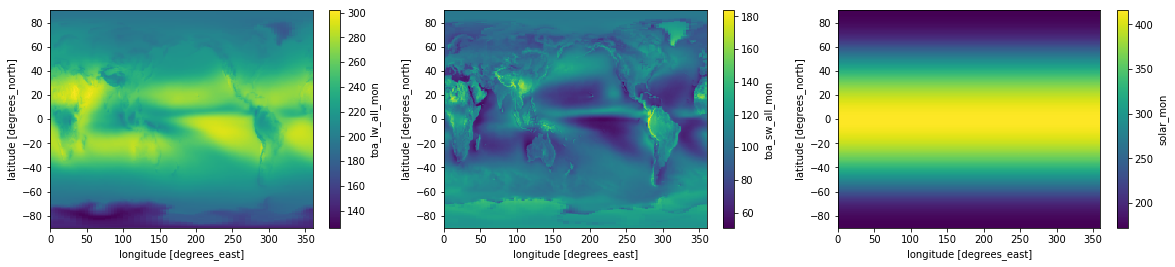

In [6]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4)) 
ax1, ax2, ax3 = axes


timemean.toa_lw_all_mon.plot(ax=ax1) #longwave
timemean.toa_sw_all_mon.plot(ax=ax2) #shortwave
timemean.solar_mon.plot(ax=ax3) #solar radiaion

ax1.autoscale()
ax2.autoscale()
ax3.autoscale()




## 2.3) Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux

Again, you have to pay attention to and think about the sign conventions for each variable in order to get this to work.

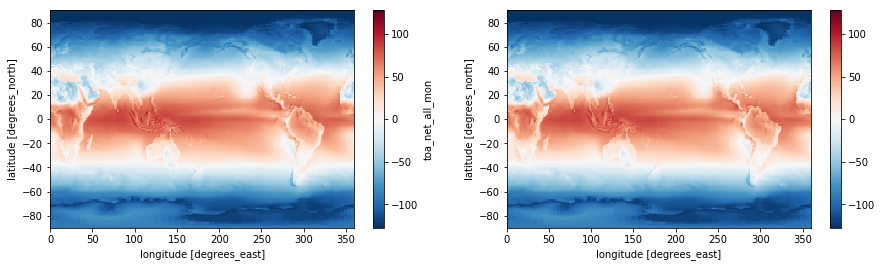

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(15,4)) 
ax1, ax2 = axes

#net flux = incoming solar radiation - (shortwave + longwave radiation)
netflux =  timemean.solar_mon - (timemean.toa_lw_all_mon + timemean.toa_sw_all_mon)


timemean.toa_net_all_mon.plot(ax=ax1)
netflux.plot(ax=ax2)
# specify vmin, vmax to change color map -- automatically scales

## 3.1) Calculate the global mean of TOA net radiation directly from the dataset

Since the Earth is approximately in radiative balance, the net TOA radiation should be zero. But taking the naive mean from this dataset, you should find a number far from zero. Why?

In [8]:
# radiation - net radiation is flux integrated over globe

netflux2 =  timemean.solar_mon - (timemean.toa_lw_all_mon + timemean.toa_sw_all_mon)
netrad = netflux2.mean(dim=('lat','lon'))
netrad

<xarray.DataArray ()>
array(-28.728985, dtype=float32)

The answer is that each "pixel" or "grid point" of this dataset does not represent an equal area of Earth's surface. So naively taking the mean, i.e. giving equal weight to each point, gives the wrong answer.

On a lat / lon grid, the relative area of each grid point is proportional to $\cos(\lambda)$. ($\lambda$ is latitude)

## 3.2) Create a `weight` array proportional to $\cos(\lambda)$ with a mean value of 1

Verify its mean is 1 and plot it. Be careful about radians vs. degrees.

<xarray.DataArray 'lat' ()>
array(1., dtype=float32)


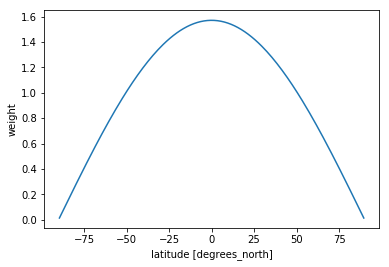

In [63]:
weight0 = np.cos( ds.lat * np.pi/180)
mean = weight0.mean()

#normalized
weight = weight0 / mean

fig, ax = plt.subplots()

weight.plot(ax=ax) #should equal 1
ax.set_ylabel('weight')
print(weight.mean()) 


## 3.3) Redo your global mean TOA net radiation calculation with this weight factor


Remember Xarray's [handling of broadcasting](http://xarray.pydata.org/en/stable/computation.html#broadcasting-by-dimension-name). Don't make this harder than it needs to be.

In [64]:
# radiation with WEIGHTED dataset - net radiation is flux integrated over globe

# weighted values of solar rad, sw and lw wavelengths
solw = timemean.solar_mon*weight
lww = timemean.toa_lw_all_mon*weight
sww = timemean.toa_sw_all_mon*weight

netfluxw =  solw - ( lww + sww)
netradw = netfluxw.mean(dim=('lat','lon'))


netradw #yes, smaller than |-28|

<xarray.DataArray ()>
array(0.878104, dtype=float32)

This time around, you should have found something much closer to zero. Ask a climate scientist what the net energy imbalance of Earth due to global warming is estimate to be. Do you think our calculation is precise enough to detect this? 

## 3.4) Now that you have a `weight` factor, verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with the cartoon above

In [65]:
print(solw.mean(dim=('lat','lon')))
print(lww.mean(dim=('lat','lon')))
print(sww.mean(dim=('lat','lon')))

# yes they match

<xarray.DataArray ()>
array(340.28513, dtype=float32)
<xarray.DataArray ()>
array(240.26799, dtype=float32)
<xarray.DataArray ()>
array(99.139046, dtype=float32)


We can go beyond a weight factor and actually calculate the area of each pixel of the dataset, using the formula

$$ dA = R^2 \cos(\lambda) d\lambda d \varphi $$

where $d\lambda$ and $d\varphi$ are the spacing of the points in latitude and longitude (measured in radians). We can approximate Earth's radius as $R = 6,371$ km.

## 4.1) calculate the pixel area using this formula and create a 2D (lon, lat) DataArray for it

(Xarray's `ones_like` function can help you easily create and broadcast DataArrays.) Verify that the sum of all the pixels equals the Earth's true surface area as evaluated using the formula for the area of a sphere (yes, I know the Earth is not a sphere...it's just a homework problem).

In [66]:
R = 6371e3 ; #m

## spacing of lat, lon are 1 degrees, 
#one degree = pi/180 radians

dlamda = xr.ones_like(ds.lat) * np.pi/180
dpsi = xr.ones_like(ds.lon) * np.pi/180

#calc dA
dA = R**2 * np.cos( ds.lat * np.pi/180) * dlamda * dpsi
A = np.sum(dA)

A

<xarray.DataArray ()>
array(5.10071e+14, dtype=float32)

In [67]:
#surf area sphere
SA_sphere = 4 * np.pi * R**2
SA_sphere

#Yes! Agrees

510064471909788.25

Multiplying the pixel area from above with the radiative flux gives you the total amount of radiation absorbed in each pixel

## 4.2) Calculate and plot the total amount of net radiation in each 1-degree latitude band


Label with correct units

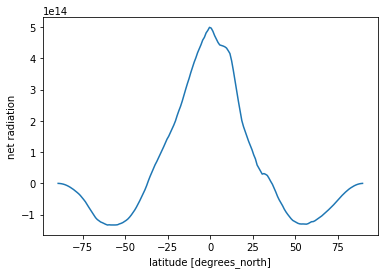

In [68]:
#weighted net flux

netfluxw =  solw - ( lww + sww)

netflux_lon = netfluxw[0,:] 
dnetRad = netfluxw * dA
netflux_area_by_lat_tot = np.sum(dnetRad,1)

fig, ax = plt.subplots()

netflux_area_by_lat_tot.plot(ax=ax)

ax.set_ylabel('net radiation');





## 4.3) Plot the cumulatuve sum in latitude of that quantity

Label with correct units. (Hint: check out xarray's [cumsum](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.cumsum.html) function.)

This curve tells you how much energy must be transported meridionally by the ocean and atmosphere in order to account for the radiative imbalance at the top of the atmosphere.

Text(0,0.5,'Cumulative net radiation')

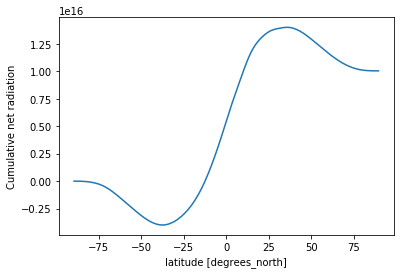

In [69]:
fig, ax = plt.subplots()

xr.DataArray.cumsum(netflux_area_by_lat_tot).plot(ax=ax)

ax.set_ylabel('Cumulative net radiation')

You should get a curve tht looks something like this

![meridional energy transport](http://www.cgd.ucar.edu/cas/papers/jclim2001a/Fig7.gif)

## 5.1) Plot the time-mean cloud area fraction (day and night)

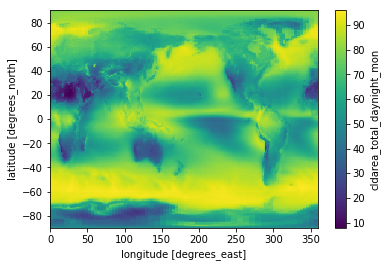

In [70]:
# cldarea_total_daynight_mon Cloud Area Fraction, Monthly Means, Daytime-and-Nighttime conditions
cloud = ds.cldarea_total_daynight_mon
cloud_timemean = cloud.mean(dim='time')
cloud_timemean.plot();

## 5.2) Define boolean masks for low cloud area ($\le$ 25%) and high cloud area ($\ge$ 75%)

Use the whole dataset, not the time mean.

In [71]:
mask_lowcloud = (cloud<=25)
mask_hicloud = (cloud>=75)

## 5.3) Calculate and plot composites of time-mean outgoing shortwave and longwave radiation for low and high cloud area regions

Your results should be 2D maps.

Xarray's [where](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) function will be helpful.

In [72]:
# get time means of lw rad and sw rad
lw_tm = timemean.toa_lw_all_mon
sw_tm = timemean.toa_sw_all_mon


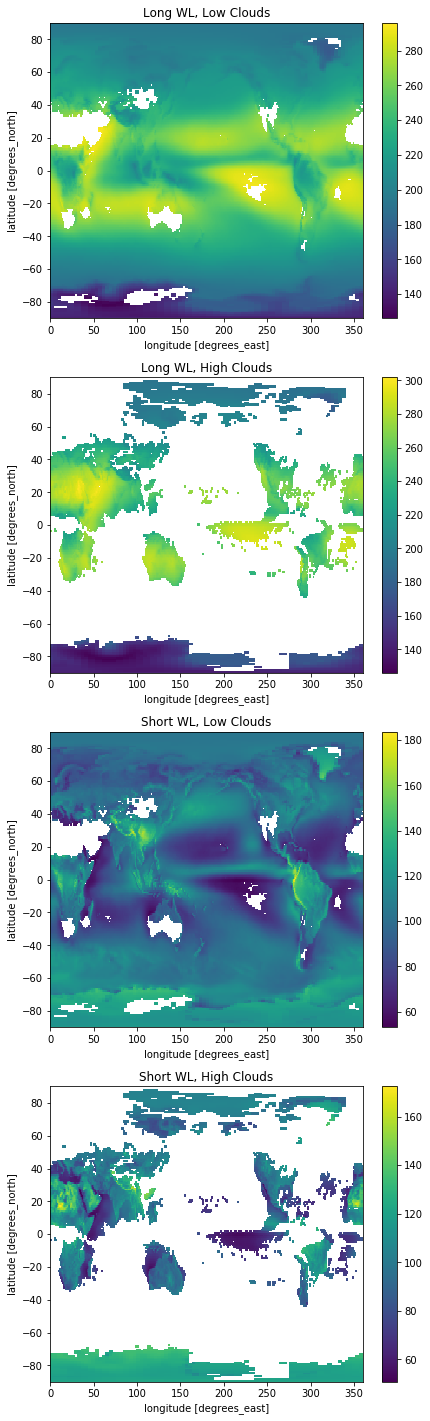

In [73]:
fig, axes = plt.subplots(nrows=4, figsize=(7,25))
ax1,ax2,ax3,ax4 = axes


lw_tm.where(mask_lowcloud).mean(dim='time').plot(ax=ax2)
lw_tm.where(mask_hicloud).mean(dim='time').plot(ax=ax1)

sw_tm.where(mask_lowcloud).mean(dim='time').plot(ax=ax4)
sw_tm.where(mask_hicloud).mean(dim='time').plot(ax=ax3)


ax1.set_title('Long WL, Low Clouds')
ax2.set_title('Long WL, High Clouds')

ax3.set_title('Short WL, Low Clouds')
ax4.set_title('Short WL, High Clouds');


## 5.4) Using the `weight` factor from 3.2, calculate the global mean values of shortwave and longwave radiation, composited in high and low cloud regions

What is the overall effect of clouds on shortwave and longwave radiation?

Clouds reflect shortwave radiation and block longwave radiation

In [76]:
# weighted long and short wave fluxes
lww = timemean.toa_lw_all_mon*weight
sww = timemean.toa_sw_all_mon*weight

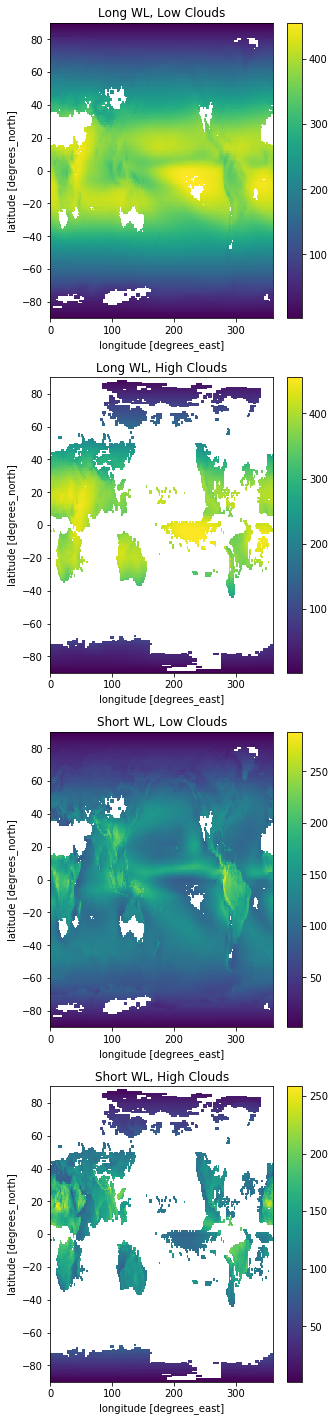

In [77]:
fig, axes = plt.subplots(nrows=4, figsize=(5,25))
ax1,ax2,ax3,ax4 = axes


lww.where(mask_lowcloud).mean(dim='time').plot(ax=ax2)
lww.where(mask_hicloud).mean(dim='time').plot(ax=ax1)

sww.where(mask_lowcloud).mean(dim='time').plot(ax=ax4)
sww.where(mask_hicloud).mean(dim='time').plot(ax=ax3)


ax1.set_title('Long WL, Low Clouds')
ax2.set_title('Long WL, High Clouds')

ax3.set_title('Short WL, Low Clouds')
ax4.set_title('Short WL, High Clouds');